In [22]:
import warnings
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

%matplotlib inline

In [10]:
folder_path = './air_quality'

# 获取文件夹中的所有文件名
filenames = os.listdir(folder_path)

# 读取所有 CSV 文件
Air_Qualities = {filename.split('_')[2]: pd.read_csv(os.path.join(folder_path, filename)) for filename in filenames if filename.endswith('.csv')}

POLLUTIONS = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']

warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Load the data
AoTi = pd.read_csv('./air_quality/PRSA_Data_Aotizhongxin_20130301-20170228.csv')
AoTi['datetime'] = pd.to_datetime(AoTi[['year', 'month', 'day', 'hour']])
AoTi = AoTi.dropna()
AoTi.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00


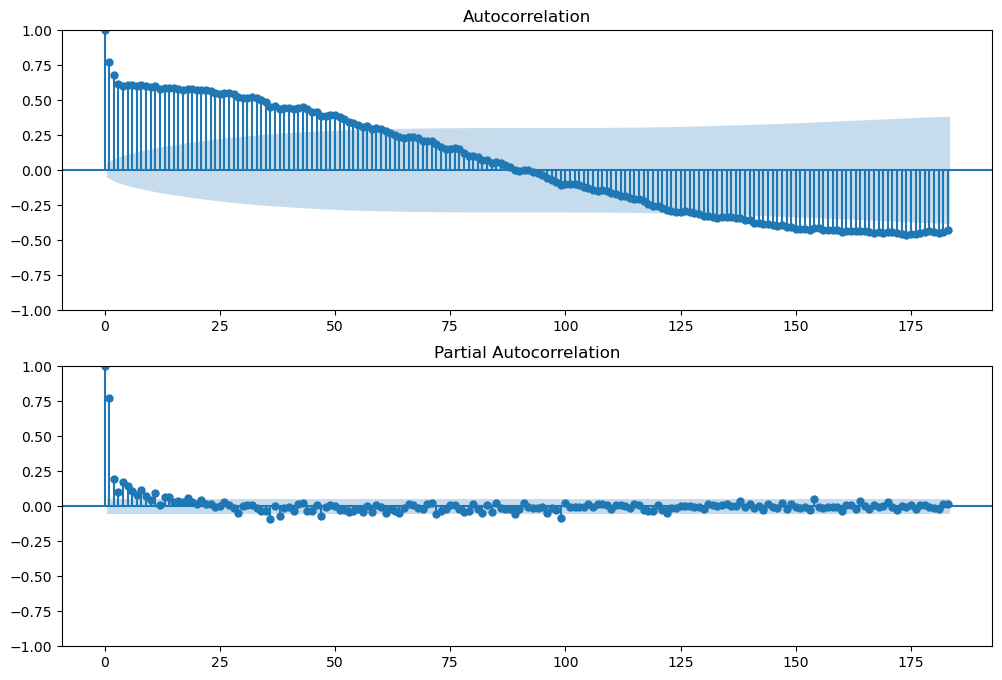

In [3]:
o3 = AoTi[['datetime', 'O3']]
o3_daily = o3.copy().set_index('datetime').resample('D').mean().reset_index().dropna()

# Plot the acf and pacf
fig, ax = plt.subplots(2,1, figsize=(12,8))
sm.tsa.graphics.plot_acf(o3_daily['O3'], lags=183, ax=ax[0])
sm.tsa.graphics.plot_pacf(o3_daily['O3'], lags=183, ax=ax[1])
plt.show()

In [4]:
o3_daily['o3_diff1'] = o3_daily['O3'].diff()
o3_daily['o3_diff2'] = o3_daily['o3_diff1'].diff()
o3_daily.head()


,datetime,O3,o3_diff1,o3_diff2
0,2013-03-01,63.875000,NaN,NaN
1,2013-03-02,29.750000,-34.125000,NaN
2,2013-03-03,19.125000,-10.625000,23.500000
3,2013-03-04,52.523810,33.398810,44.023810
4,2013-03-05,68.458333,15.934524,-17.464286


f:\ComputerSciEnv\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\ComputerSciEnv\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\ComputerSciEnv\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
f:\ComputerSciEnv\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

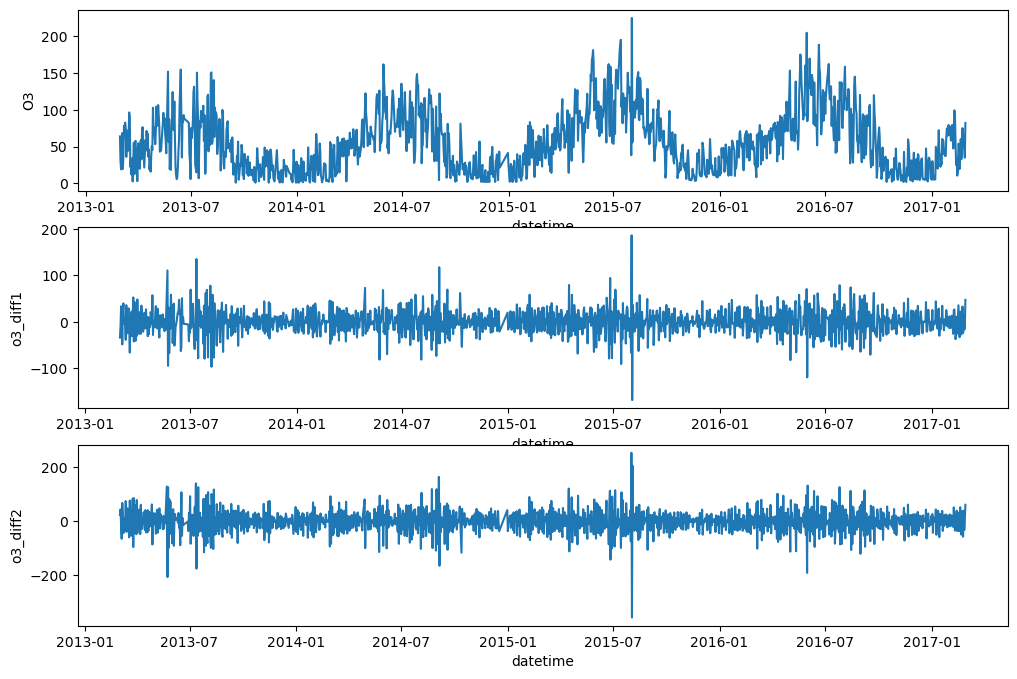

In [5]:
fig, ax = plt.subplots(3,1, figsize=(12,8))
for i in range(1, 4):
    sns.lineplot(x='datetime', y=o3_daily.columns[i], data=o3_daily, ax=ax[i-1])

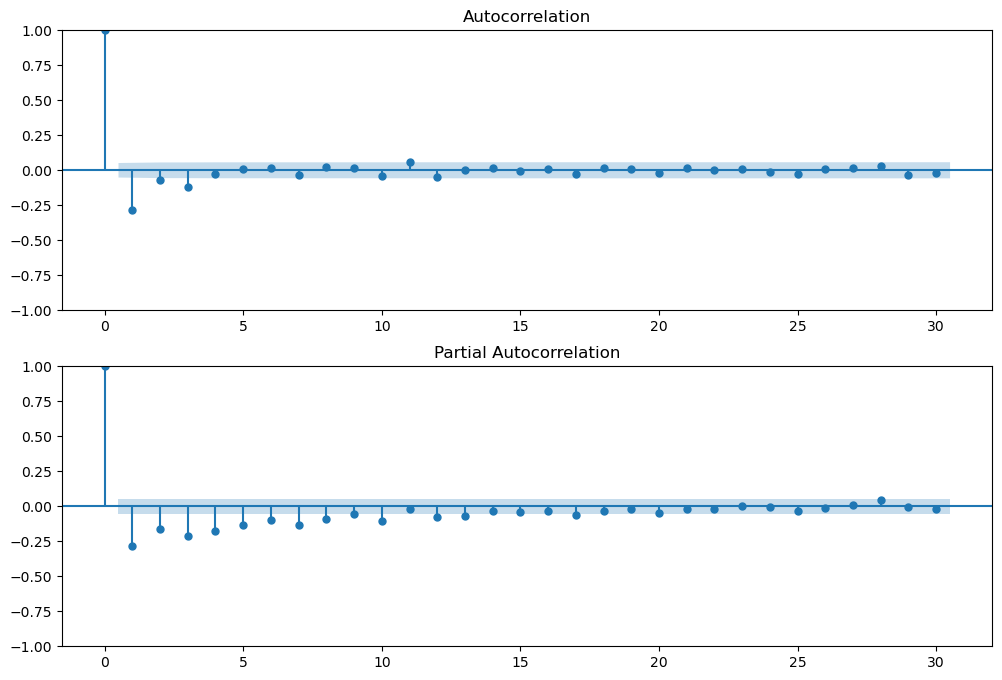

In [6]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sm.tsa.graphics.plot_acf(o3_daily['o3_diff1'].dropna(), lags=30, ax=ax[0])
sm.tsa.graphics.plot_pacf(o3_daily['o3_diff1'].dropna(), lags=30, ax=ax[1])
plt.show()

In [46]:
O3_SO2 = {position: Air_Qualities[position][['year', 'month', 'day', 'hour', 'SO2', 'O3']] for position in Air_Qualities}

In [48]:
O3_SO2_Daily: dict[str, pd.DataFrame] = {}
for position in O3_SO2:
    O3_SO2[position]['date'] = pd.to_datetime(O3_SO2[position][['year', 'month', 'day']])
    O3_SO2[position] = O3_SO2[position].dropna()
    O3_SO2_Daily[position] = O3_SO2[position].groupby('date').mean().reset_index()
    O3_SO2_Daily[position]['station'] = position
    O3_SO2_Daily[position] = O3_SO2_Daily[position].astype({'year': 'int', 'month': 'int', 'day': 'int'})
    O3_SO2_Daily[position]['O3_rollmean'] = gaussian_filter1d(O3_SO2_Daily[position]['O3'], sigma=28)
    O3_SO2_Daily[position]['SO2_rollmean'] = gaussian_filter1d(O3_SO2_Daily[position]['SO2'], sigma=28)
    print(O3_SO2_Daily[position].tail())
    # O3_SO2[position] = O3_SO2[position].dropna()

           date  year  month  day       hour        SO2         O3  \
1436 2017-02-24  2017      2   24  11.500000  16.583333  50.791667   
1437 2017-02-25  2017      2   25  11.500000   6.750000  65.875000   
1438 2017-02-26  2017      2   26  11.500000  10.083333  48.625000   
1439 2017-02-27  2017      2   27  11.428571  18.809524  34.952381   
1440 2017-02-28  2017      2   28  11.500000   9.125000  82.208333   

           station  O3_rollmean  SO2_rollmean  
1436  Aotizhongxin    50.788587     21.047280  
1437  Aotizhongxin    50.842594     21.047814  
1438  Aotizhongxin    50.882983     21.048172  
1439  Aotizhongxin    50.909862     21.048366  
1440  Aotizhongxin    50.923249     21.048514  
           date  year  month  day       hour        SO2         O3    station  \
1452 2017-02-24  2017      2   24  11.500000   9.958333  40.833333  Changping   
1453 2017-02-25  2017      2   25  11.500000   8.125000  48.833333  Changping   
1454 2017-02-26  2017      2   26  11.500000  12

In [49]:
O3_SO2_Position = pd.concat(O3_SO2_Daily.values())

<Axes: xlabel='SO2_rollmean', ylabel='O3_rollmean'>

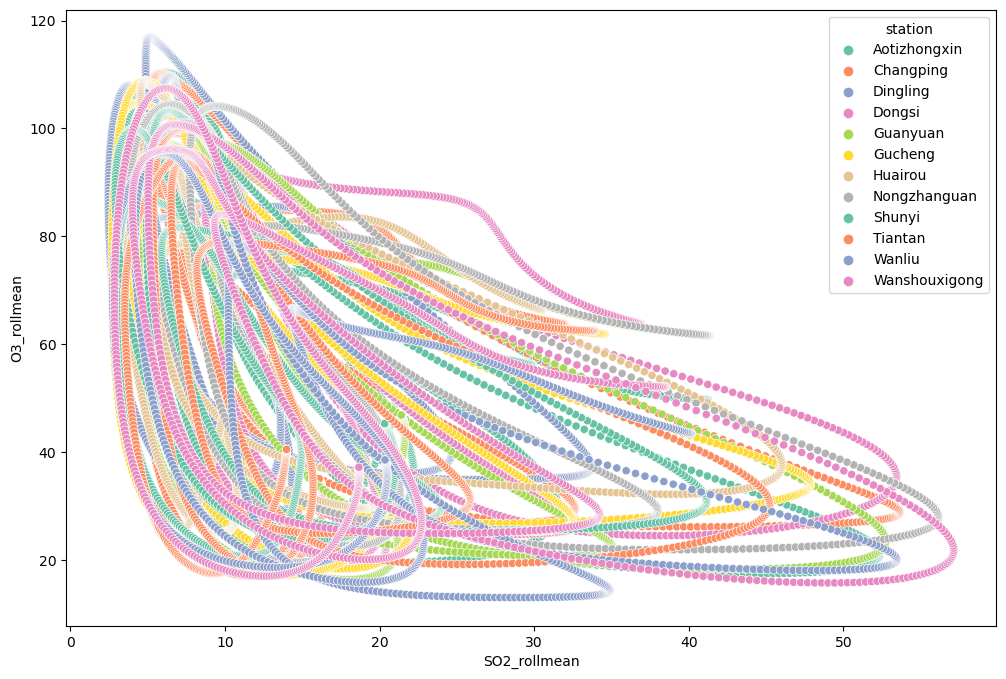

In [51]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x='SO2_rollmean',
    y='O3_rollmean',
    hue='station',
    data=O3_SO2_Position,
    palette='Set2'
)

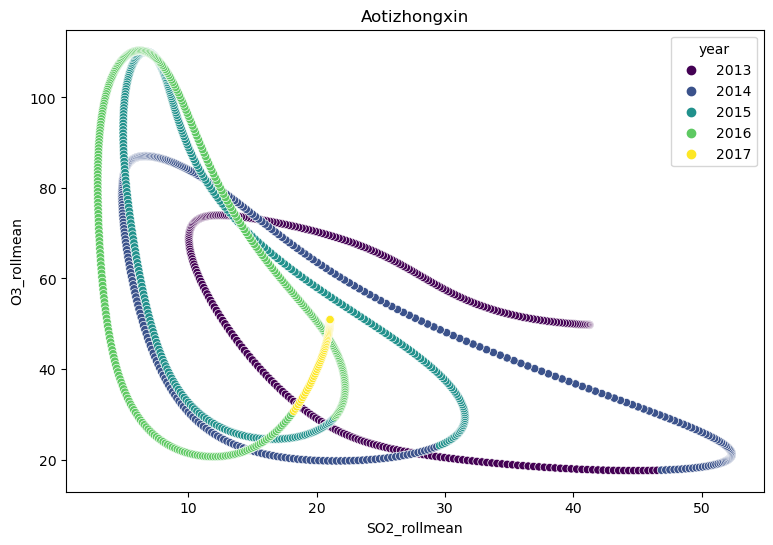

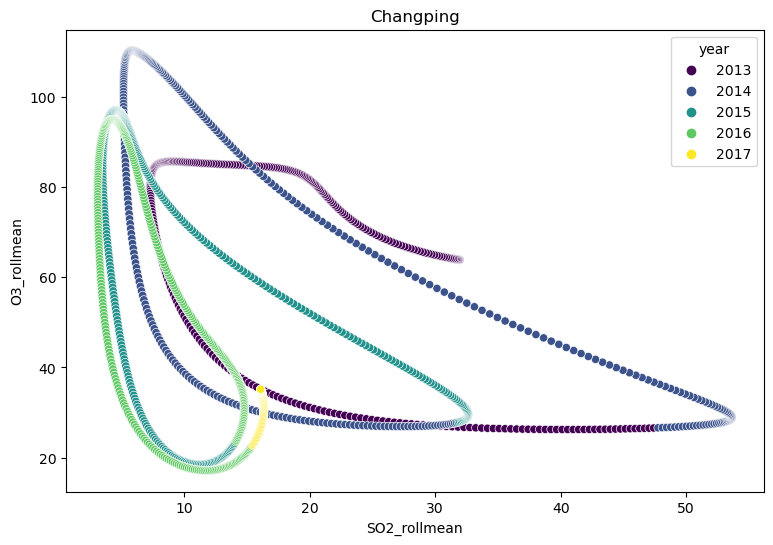

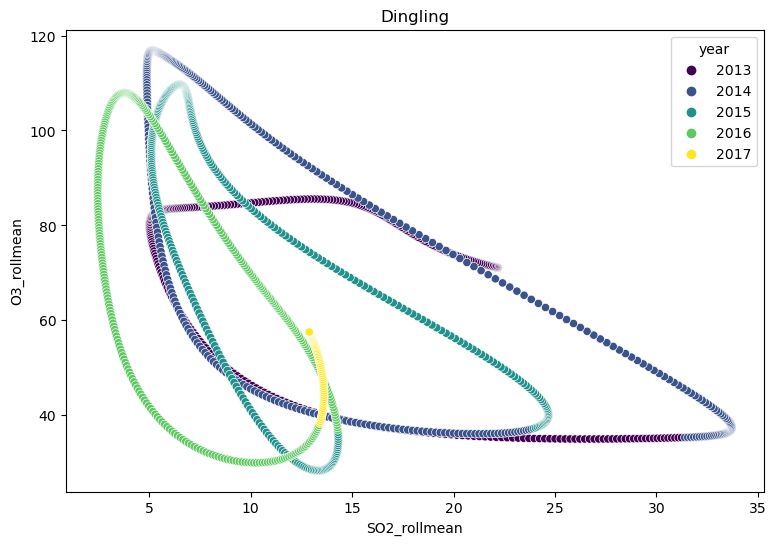

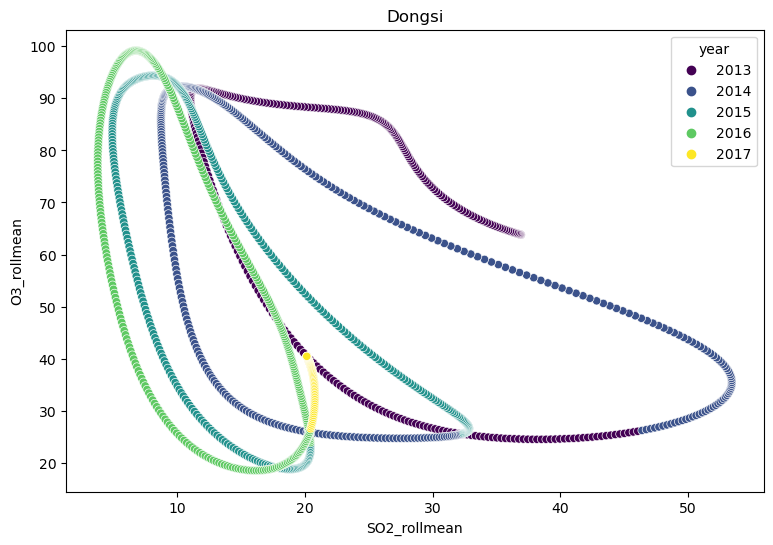

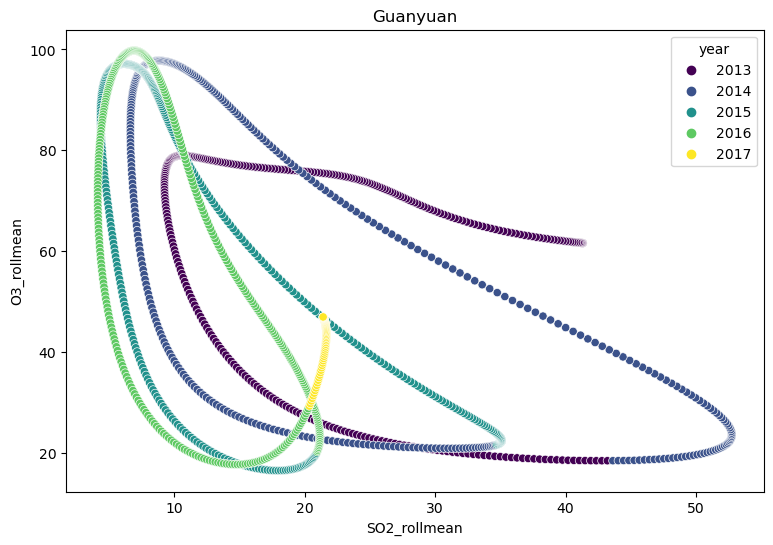

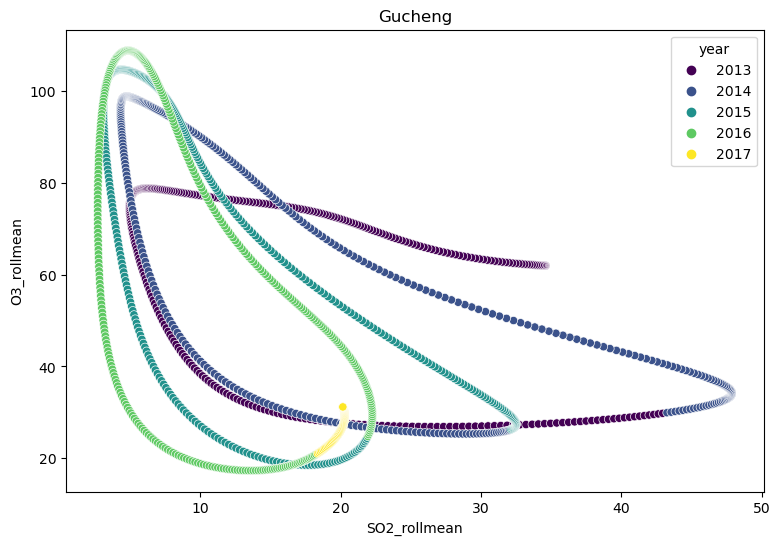

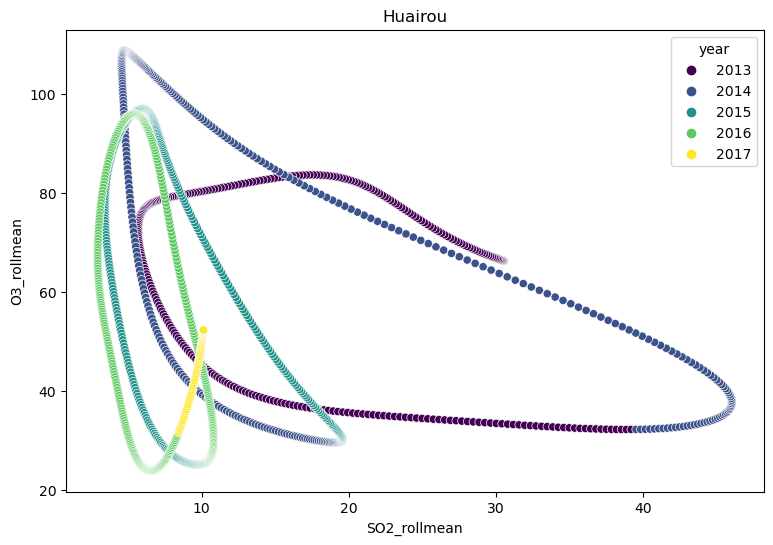

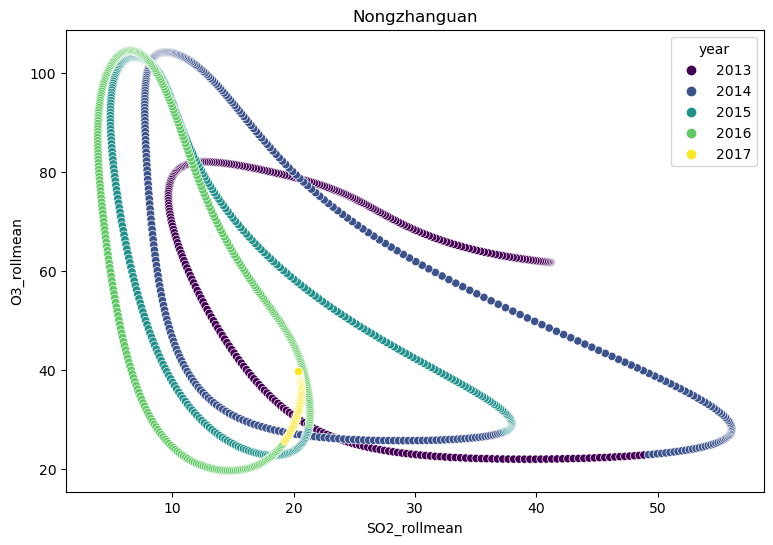

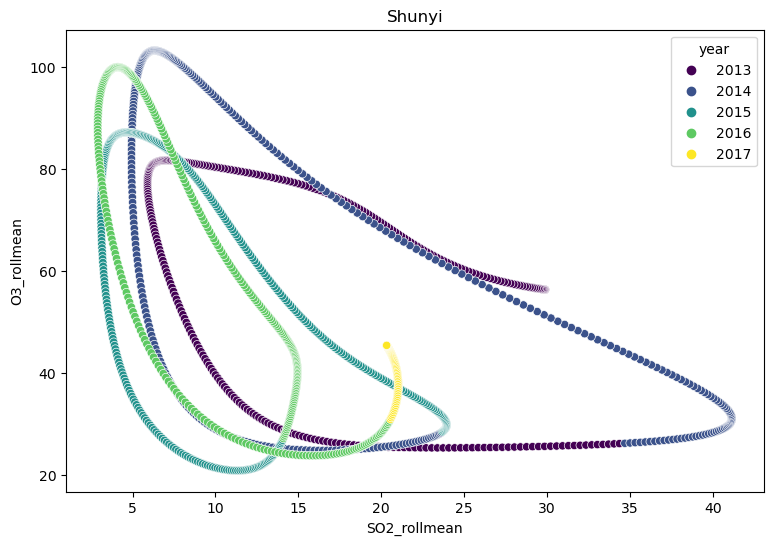

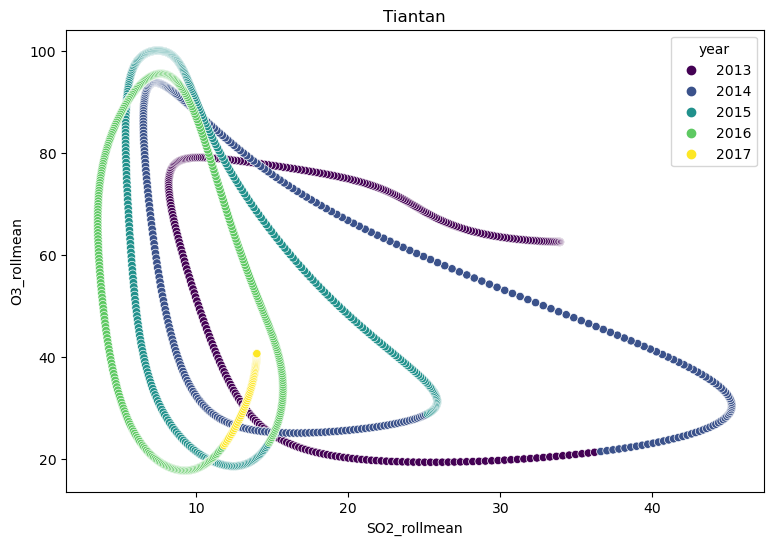

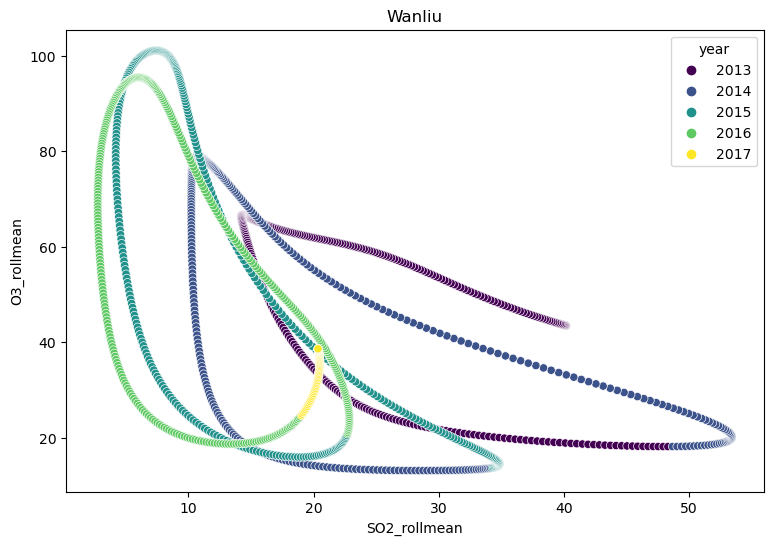

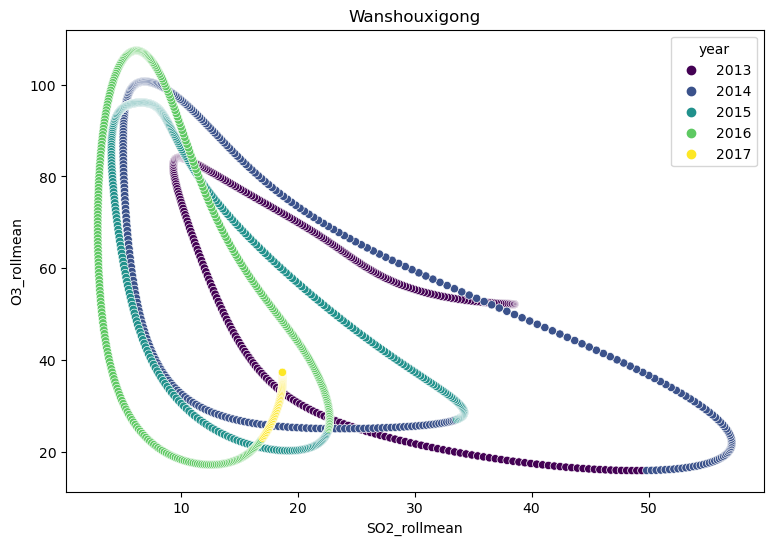

In [42]:
for position in O3_SO2_Daily:
    # df = O3_SO2[position].groupby('day').mean().reset_index()
    plt.figure(figsize=(9,6))
    sns.scatterplot(
        x='SO2_rollmean',
        y='O3_rollmean',
        data=O3_SO2_Daily[position],
        hue='year',
        palette='viridis',
    )
    plt.title(position)